In [ ]:
#!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip

In [ ]:
!git clone https://github.com/niazwazir/SRCNN-Keras.git

In [ ]:
cd SRCNN-Keras/

In [ ]:
!ls

In [ ]:
!unzip yang91.zip

In [ ]:
!ls

In [ ]:
!rm -r *.zip

In [ ]:
!ls

In [ ]:
cd ..

In [ ]:
!ls

In [ ]:
!unzip "DIV2K_train_HR.zip"

In [ ]:
!rm -r *.zip

In [ ]:
!ls

In [2]:
DATADIR = "SRCNN-Keras/Set5"
DATADIR2 = "SRCNN-Keras/yang91"
#DATADIR2 = "DIV2K_train_HR"

In [3]:
import os
import cv2
import keras
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
#from google.colab.patches import cv2_imshow
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, PReLU,Conv2D, Dropout, SeparableConv2D,MaxPooling2D,Concatenate,AveragePooling2D,GlobalMaxPooling2D,BatchNormalization, Input,Conv2DTranspose, add, Activation, LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD

In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, add, PReLU, Conv2DTranspose

In [5]:
import matplotlib.pyplot as plt, glob
import tensorflow.keras as K
import cv2
import numpy as np

In [6]:
input_size=32
scale = 2
batch_size=16

In [7]:
scale = 2
req_size = 32
inp_size = int(req_size/scale)
stride = 15

X=[]
labels=[]

for filera in os.listdir(DATADIR):
    readpath = os.path.join(DATADIR,filera)
    img = cv2.imread(readpath)
    img = np.asarray(img)
    shapes = img.shape
    for i in range(0, shapes[0]-req_size+1, stride):
        for j in range(0, shapes[1]-req_size+1,stride):
            subimage_HR = img[i:i+req_size, j:j+req_size]
            #cv2_imshow(subimage_HR)
            subimage_LR = cv2.resize(subimage_HR,(inp_size,inp_size))
            X.append(subimage_LR)
            labels.append(subimage_HR)

counta=0
for filera in os.listdir(DATADIR2):
    counta=counta+1
    if(counta==300):
        break
        readpath = os.path.join(DATADIR2,filera)
        img = cv2.imread(readpath)
        img = np.asarray(img)
        shapes = img.shape
        for i in range(0, shapes[0]-req_size+1, stride):
            for j in range(0, shapes[1]-req_size+1,stride):
                subimage_HR = img[i:i+req_size, j:j+req_size]
                #cv2_imshow(subimage_HR)
                subimage_LR = cv2.resize(subimage_HR,(inp_size,inp_size))
                X.append(subimage_LR)
                labels.append(subimage_HR)

In [8]:
X = np.asarray(X)
labels = np.asarray(labels)
print(labels.shape)
print(X.shape)

(2221, 32, 32, 3)
(2221, 16, 16, 3)


In [9]:
alpha = 1
def basic_mse(y_true, y_pred):
    pred = tf.image.sobel_edges(y_pred)
    true = tf.image.sobel_edges(y_true)
    lossmse = tf.reduce_mean(tf.square(y_pred-y_true))
    lossedge = tf.reduce_mean(tf.square(pred-true))
    return alpha*lossmse + (1-alpha)*lossedge

In [10]:
def SEB_block():
    inputlayer = Input(shape=(None,None,3))
    #SQUEEZE STAGE
    PC1 = Conv2D(32,(1,1),name='1x1_A',padding='SAME')(inputlayer)
    PC2 = Conv2D(32,(1,1),name='1x1_B',padding='SAME')(inputlayer)
    PC3 = Conv2D(32,(1,1),name='1x1_C',padding='SAME')(inputlayer)
    PC4 = Conv2D(32,(1,1),name='1x1_D',padding='SAME')(inputlayer)
    Sum1 = add([PC1,PC2,PC3,PC4])
    PPC1 = PReLU(shared_axes=[1,2])(Sum1)
    
    #EXPAND STAGE
    PC5 = Conv2D(32,(1,1),name='1x1_E',padding='SAME')(PPC1)
    DWC5  = Conv2D(32,(3,3),name='3x3_A',padding='SAME')(PC5)
    
    PC6 = Conv2D(32,(1,1),name='1x1_F',padding='SAME')(PPC1)
    DWC6  = Conv2D(32,(3,3),name='3x3_B',padding='SAME')(PC6)
    
    PC7 = Conv2D(32,(1,1),name='1x1_G',padding='SAME')(PPC1)
    DWC7  = Conv2D(32,(3,3),name='3x3_C',padding='SAME')(PC7)
    
    PC8 = Conv2D(32,(1,1),name='1x1_H',padding='SAME')(PPC1)
    DWC8  = Conv2D(32,(3,3),name='3x3_D',padding='SAME')(PC8)
    
    PC9 = Conv2D(32,(1,1),name='1x1_I',padding='SAME')(PPC1)
    DWC9  = Conv2D(32,(3,3),name='3x3_E',padding='SAME')(PC9)
    
    PC10 = Conv2D(32,(1,1),name='1x1J',padding='SAME')(PPC1)
    DWC10  = Conv2D(32,(3,3),name='3x3_F',padding='SAME')(PC10)
    
    PC11 = Conv2D(32,(1,1),name='1x1_K',padding='SAME')(PPC1)
    DWC11  = Conv2D(32,(3,3),name='3x3_G',padding='SAME')(PC11)
    
    PC12 = Conv2D(32,(1,1),name='1x1L',padding='SAME')(PPC1)
    DWC12  = Conv2D(32,(3,3),name='3x3_H',padding='SAME')(PC12)
    
    Sum2  = add([DWC5,DWC6,DWC7,DWC8,DWC9,DWC10,DWC11,DWC12])
    PPC2 = PReLU(shared_axes=[1,2])(Sum2)
    model = Model(inputs=inputlayer , outputs = PPC2)
    return model
model = SEB_block()

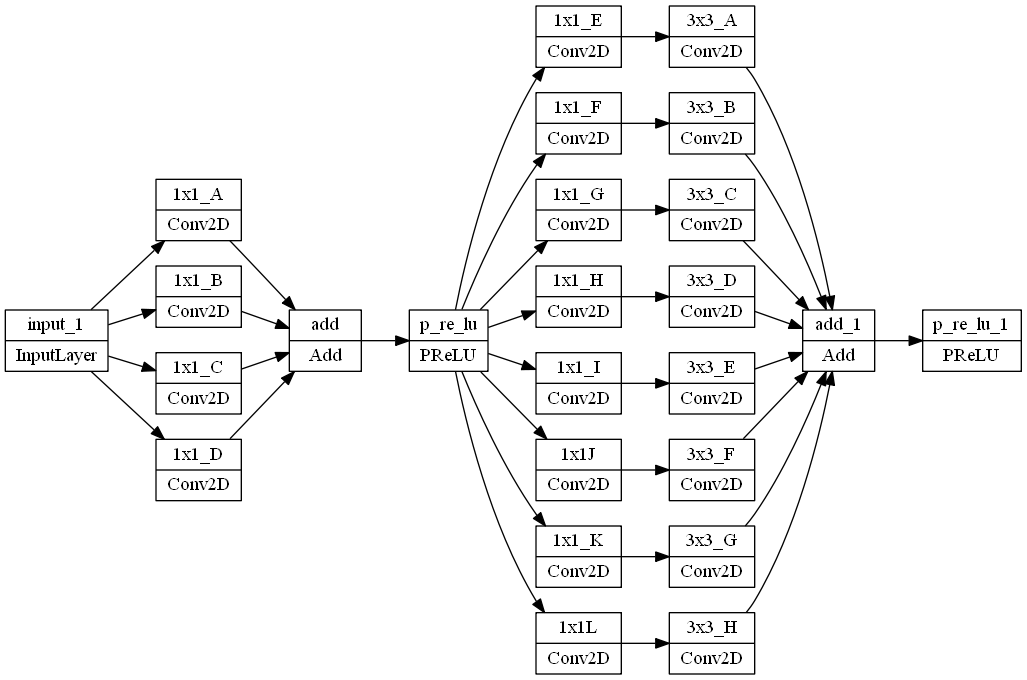

In [11]:
plot_model(
    model,to_file='model.png',show_shapes=False,show_layer_names=True,rankdir='LR',expand_nested=False,dpi=96)

In [12]:
inputlayer = Input(shape=(None,None,3))
C1 = Conv2D(3, (3,3), padding="same")(inputlayer)
L1 =  PReLU(shared_axes=[1,2])(C1)

###BLOCKS
F1 = SEB_block()(L1)
U1 = Conv2D(3, (3,3),padding="same")(F1)
F2 = SEB_block()(L1)
U2 = Conv2D(3, (3,3),padding="same")(F2)
F3 = SEB_block()(L1)
U3 = Conv2D(3, (3,3),padding="same")(F3)
F4 = SEB_block()(L1)
U4 = Conv2D(3, (3,3),padding="same")(F4)
F5 = SEB_block()(L1)
U5 = Conv2D(3, (3,3),padding="same")(F5)

SumF  = add([L1,U1,U2,U3,U4,U5])
y = Conv2DTranspose(1,(9,9), strides = (2,2), padding="same",activation=None)(SumF)

CL1 = Conv2D(1,(3,3), padding="same")(y)
CL2 = Conv2D(1,(3,3), padding="same")(CL1)
CL3 = Conv2D(1,(3,3), padding="same")(CL2)
LL =  PReLU(shared_axes=[1,2])(CL3)
model = Model(inputs=inputlayer , outputs = LL)
model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])

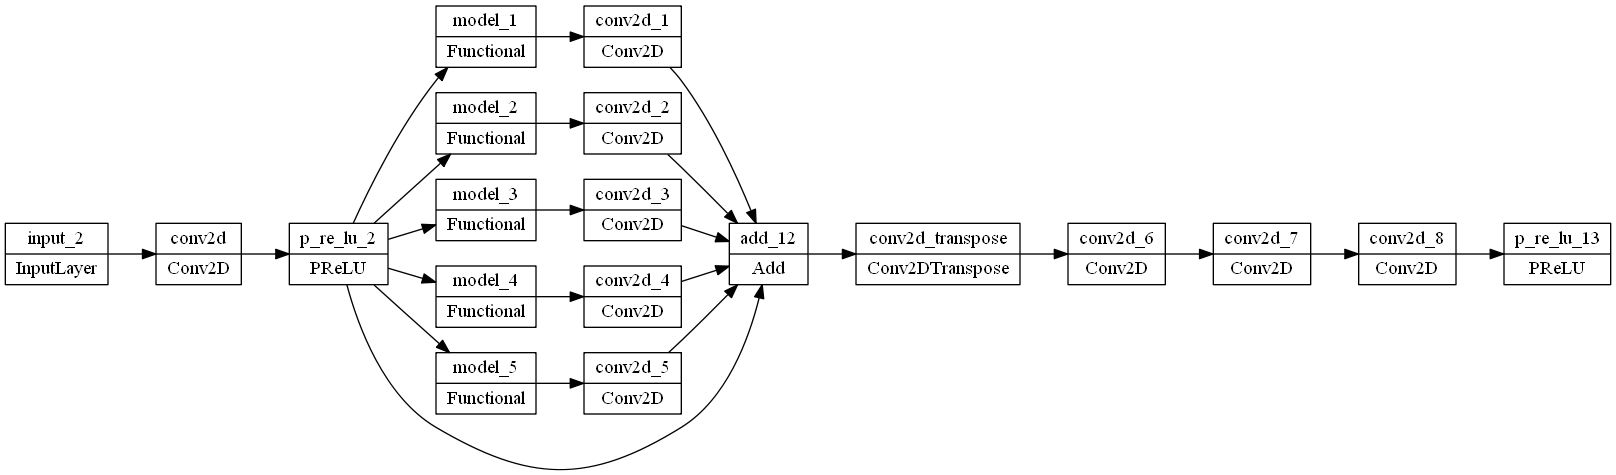

In [13]:
plot_model(model,to_file='model.png',show_shapes=False,show_layer_names=True,rankdir='LR',expand_nested=False,dpi=96)

In [14]:
from keras_flops import get_flops
flops = get_flops(model, batch_size=1)
print(f"FLOPS: {flops / 10 ** 9:.03} G")

Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`
FLOPS: 3.26e-07 G


In [15]:
print(model.summary())

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   84          ['input_2[0][0]']                
                                3)                                                                
                                                                                                  
 p_re_lu_2 (PReLU)              (None, None, None,   3           ['conv2d[0][0]']                 
                                3)                                                          

In [16]:
def psnr(y_true,y_pred):
    return tf.image.psnr(y_true,y_pred,1.0)
def ssim(y_true,y_pred):
    return tf.image.ssim(y_true,y_pred,1.0)
def mean_squared_error(y_true, y_pred):
    return tf.keras.metrics.mean_squared_error(y_true, y_pred)

In [17]:
model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])

In [18]:
checkpoint = ModelCheckpoint('best_model_improved.h5',  # model filename
                             monitor='val_loss', # quantity to monitor
                             verbose=0, # verbosity - 0 or 1
                             save_best_only= True, # The latest best model will not be overwritten
                             mode='auto') # The decision to overwrite model is made 
                                          # automatically depending on the quantity to monitor

In [19]:
history=model.fit(X,labels,batch_size=32,shuffle=True,validation_split=0.01 ,epochs=5,verbose=1 )

Epoch 1/5
69/69 [==============================] - 15s 75ms/step - loss: 11548.1973 - accuracy: 0.0051 - val_loss: 8307.3105 - val_accuracy: 2.8306e-05
Epoch 2/5
69/69 [==============================] - 4s 55ms/step - loss: 7728.9419 - accuracy: 0.0048 - val_loss: 6103.2593 - val_accuracy: 2.8306e-05
Epoch 3/5
69/69 [==============================] - 4s 55ms/step - loss: 5090.8862 - accuracy: 0.0047 - val_loss: 3141.7102 - val_accuracy: 2.8306e-05
Epoch 4/5
69/69 [==============================] - 4s 53ms/step - loss: 3122.2200 - accuracy: 0.0046 - val_loss: 2321.2214 - val_accuracy: 2.8306e-053273.643
Epoch 5/5
69/69 [==============================] - 4s 53ms/step - loss: 2581.5312 - accuracy: 0.0046 - val_loss: 1976.1774 - val_accuracy: 2.8306e-05


Text(0.5, 1.0, 'Loss Curves')

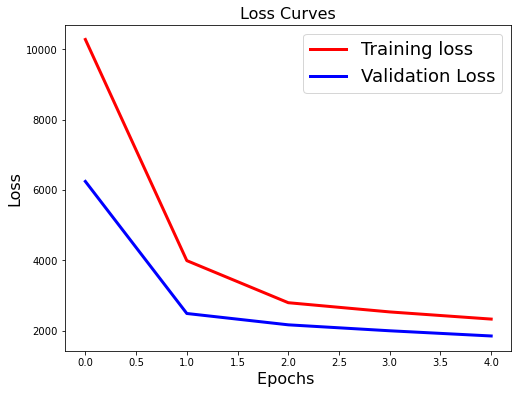

In [19]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

Text(0.5, 1.0, 'Accuracy Curves')

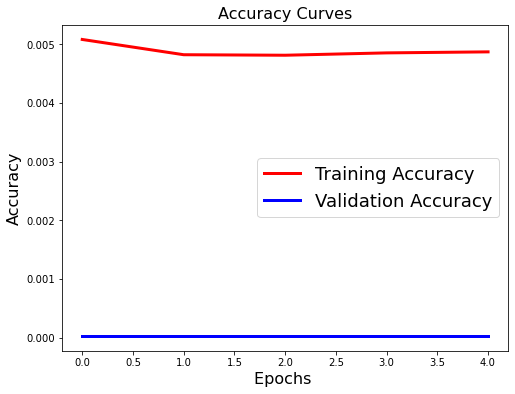

In [20]:
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [21]:
def psnr_calc():
    testimg = []
    GT = cv2.imread("SRCNN-Keras/baby_x2_GT.png")
    GT = np.asarray(GT)
    h = GT.shape[0]
    l = GT.shape[1]
    img1 = cv2.resize(GT,(int(l/4),int(h/4)),interpolation = cv2.INTER_CUBIC)
    img1 = np.asarray(img1)
    testimg.append(img1)
    testimg = np.asarray(testimg)
    print(testimg.shape)
    fin =(model.predict(testimg)[0])
    inp = cv2.resize(img1,(l,h),interpolation = cv2.INTER_CUBIC)
    GT = GT[0:fin.shape[0],0:fin.shape[1],:]
    mse = np.square(np.subtract(GT, fin)).mean()
    #cv2_imshow(inp)
    #cv2_imshow(fin)
    #cv2_imshow(GT)
    import math
    psnr = 20*math.log(255.0,10) - 10*(math.log(mse,10))
    return psnr

In [22]:
ps1 = psnr_calc()
print(ps1)

(1, 128, 128, 3)
7.871807395758758


In [ ]:
#35.27103087889881

In [ ]:
def psnr_calc():
    testimg = []
    GT = cv2.imread("SRCNN-Keras/baby_x2_GT.png")
    GT = np.asarray(GT)
    h = GT.shape[0]
    l = GT.shape[1]
    img1 = cv2.resize(GT,(int(l/2),int(h/2)),interpolation = cv2.INTER_CUBIC)
    img1 = np.asarray(img1)
    testimg.append(img1)
    testimg = np.asarray(testimg)
    print(testimg.shape)
    fin =(model.predict(testimg)[0])
    inp = cv2.resize(img1,(l,h),interpolation = cv2.INTER_CUBIC)
    GT = GT[0:fin.shape[0],0:fin.shape[1],:]
    mse = np.square(np.subtract(GT, fin)).mean()
    #cv2_imshow(inp)
    #cv2_imshow(fin)
    #cv2_imshow(GT)
    import math
    psnr = 20*math.log(255.0,10) - 10*(math.log(mse,10))
    return psnr

In [ ]:
ps1 = psnr_calc()
print(ps1)